<a href="https://colab.research.google.com/github/Abbhiraami/algorithm_scratch/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learning GNN

In this notebook, I will graphs and try predicting them

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
!pip install torch_geometric
import torch_geometric
from torch_geometric.datasets import KarateClub
### Converting data into networks
from torch_geometric.utils import to_networkx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.3 MB/s eta 0:00:00


In [3]:

### DiGraph() --> Directional graph
H = nx.DiGraph()

#adding nodes - Initally we are adding four nodes
H.add_nodes_from([
  (0, {"color": "blue", "size": 250}),

  (1, {"color": "yellow", "size": 400}),

  (2, {"color": "orange", "size": 150}),

  (3, {"color": "red", "size": 600})


])
#adding edges - 6 edges
H.add_edges_from([
  (0, 1),

  (1, 2),

  (1, 0),

  (1, 3),

  (2, 3),

  (3,0)


])

Directional Graph


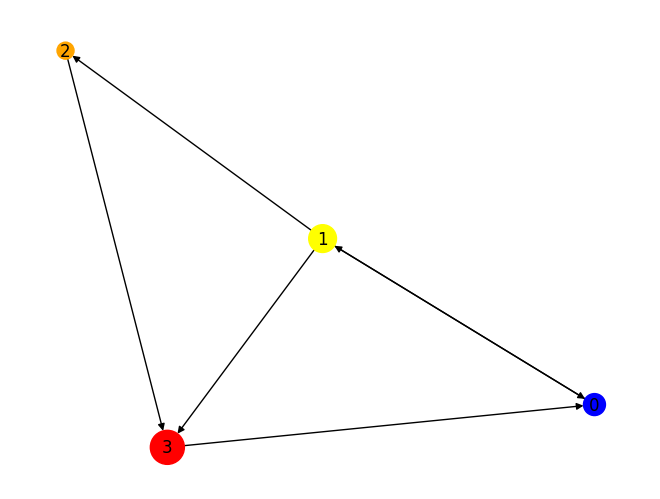

In [4]:
node_colors = nx.get_node_attributes(H, "color").values()
colors = list(node_colors)
node_sizes = nx.get_node_attributes(H, "size").values()
sizes = list(node_sizes)
### Plotting the graph created
print(f"Directional Graph")
nx.draw(H, with_labels=True, node_color=colors, node_size=sizes)


Undirected Graph
Nodes:[0, 1, 2, 3]
Edges: [(0, 1), (0, 3), (1, 2), (1, 3), (2, 3)]


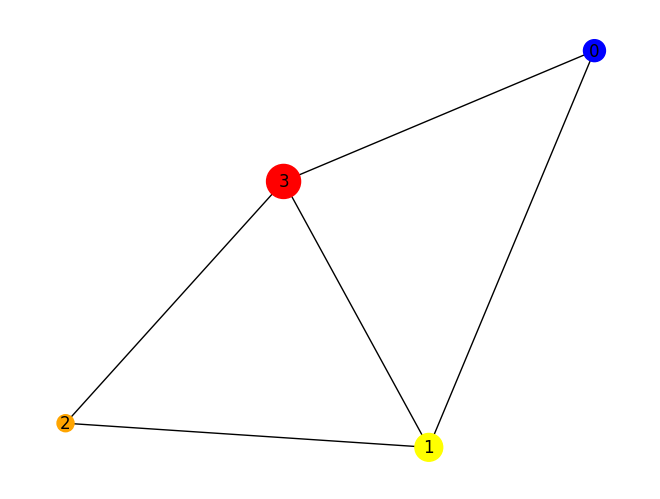

In [5]:
#### Converting to undirectional graph
J=H.to_undirected()
print(f"Undirected Graph")
nx.draw(J, with_labels=True, node_color=colors, node_size=sizes)
print(f"Nodes:{J.nodes()}")
print(f"Edges: {J.edges()}")


In [6]:
#### Karte club network
dataset = KarateClub()
print("Dataset:", dataset)
print("# Graphs:", len(dataset))
print("# Features:", dataset.num_features)
print("# Classes:", dataset.num_classes)


Dataset: KarateClub()
# Graphs: 1
# Features: 34
# Classes: 4


In [14]:
print(dataset[0])
dataset[0]['x']

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

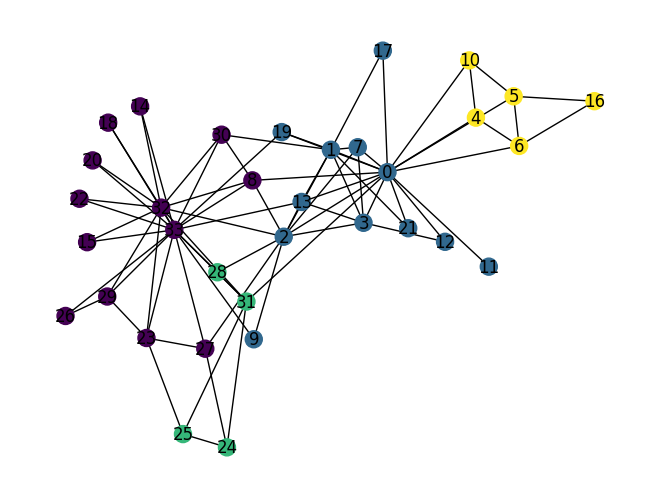

In [11]:
nx.draw(to_networkx(dataset[0],to_undirected=True),node_color=dataset.y,with_labels=True,node_size=150)

### Building GNN

Now, let's build a graph using just numpy to build a GNN from scratch

1. Let's build a simple graph with just 4 nodes
2. Create set of features for node
3. Create a degree matrix for the graph
4. Calculate the forward pass or message passing step: $H_v^{(l+1)} = σ[W^l \Sigma_{u ϵ N(v)} \frac{1}{\sqrt{deg(u) deg(v)}} * h_u^l]$

    Matrix representation, \\
    $ h_v^{l+1} = \sigma[\hat{D}^{-1/2} * \hat{A} * \hat{D}^{-1/2} * W^l * h_u^l] $
5. Training a GNN on this synethic data

In [1]:
### Importing numpy ###
import numpy as np

#### Build a simple undireected graph ###
#### A is the adjacency matrix with 4 nodes ####
A= np.array([[0,1,0,0],
             [0,1,0,0],
             [1,0,1,1],
             [0,1,0,1]
             ])
#### Node Features ####
X=np.array([[0,1],
            [1,0],
            [1,1],
            [1,0]
            ])

### Degree matrix ###
D=np.diag(np.sum(A,axis=1))
D

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 3, 0],
       [0, 0, 0, 2]])

In [15]:
###
A_hat=A+np.eye(A.shape[0])
A_hat


D_hat=np.diag(np.sum(A_hat,axis=1))
D_hat

### learnable parameters
W=np.random.randn(2,2)
W

D_hat_inv_sqrt=np.linalg.inv(np.sqrt(D_hat))
D_hat_inv_sqrt

### Normality ###
A_norm= D_hat_inv_sqrt @ A_hat @ D_hat_inv_sqrt
A_norm

### Apply GCN layer (message passing step)
H=A_norm @ X @ W
print(f'Before non-linearity:{H}\n')
### Applying non-linearity
H=np.maximum(0,H)
print(f'After non-linearity(ReLU):{H}\n')


Before non-linearity:[[-0.71533628 -0.64658405]
 [-0.46093305  0.09918894]
 [-1.19125088 -1.11022323]
 [-0.49546383  0.10661968]]

After non-linearity(ReLU):[[0.         0.        ]
 [0.         0.09918894]
 [0.         0.        ]
 [0.         0.10661968]]



Training GNN
1. Forward pass calulation
2. loss calculation: Binary cross entropy
3. Backpropagation: Update the weight matrix W using gradient descent

In [21]:
### A Simple GNN training loop
import torch

# Node labels (for example, binary classification)
y = torch.tensor([0, 1, 1, 0], dtype=torch.float)

# Convert numpy arrays to torch tensors
A_norm = torch.tensor(A_norm, dtype=torch.float)
X = torch.tensor(X, dtype=torch.float)
W = torch.tensor(W, dtype=torch.float, requires_grad=True)

# Define optimizer
optimizer = torch.optim.Adam([W], lr=0.01)

# Training loop
for epoch in range(100):
    optimizer.zero_grad()

    # Forward pass: compute node embeddings
    H = A_norm @ X @ W
    H = torch.relu(H)

    # Binary classification: compute predicted labels (using a sigmoid function)
    preds = torch.sigmoid(H[:, 0])  # Taking the first column as prediction

    # Compute binary cross-entropy loss
    loss = torch.nn.functional.binary_cross_entropy(preds, y)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.6931471824645996
Epoch 10, Loss: 0.6931471824645996
Epoch 20, Loss: 0.6931471824645996
Epoch 30, Loss: 0.6931471824645996
Epoch 40, Loss: 0.6931471824645996
Epoch 50, Loss: 0.6931471824645996
Epoch 60, Loss: 0.6931471824645996
Epoch 70, Loss: 0.6931471824645996
Epoch 80, Loss: 0.6931471824645996
Epoch 90, Loss: 0.6931471824645996


<ipython-input-21-b53eb91e6633>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_norm = torch.tensor(A_norm, dtype=torch.float)
<ipython-input-21-b53eb91e6633>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
<ipython-input-21-b53eb91e6633>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W, dtype=torch.float, requires_grad=True)


In [1]:
import numpy as np


In [6]:
array=np.array([
 [11,12, 13, 14],
 [21, 22, 23, 24],
 [31, 32, 33, 34]
    ])

In [23]:
array[-1:,]

array([[31, 32, 33, 34]])

In [24]:
array = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Extract the first row
first_row = array[0, :]

print(first_row)

[1 2 3]
